# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

Содержание
1. [Ознакомление с данными](#1) 
2. [Выполните предобработку данных](#2) 
3. [Добавьте в таблицу новые столбцы](#3) 
4. [Проведите исследовательский анализ данных](#4) 
5. [Напишите общий вывод](#5) 

<a id="1"></a> 
### Ознакомление с данными

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

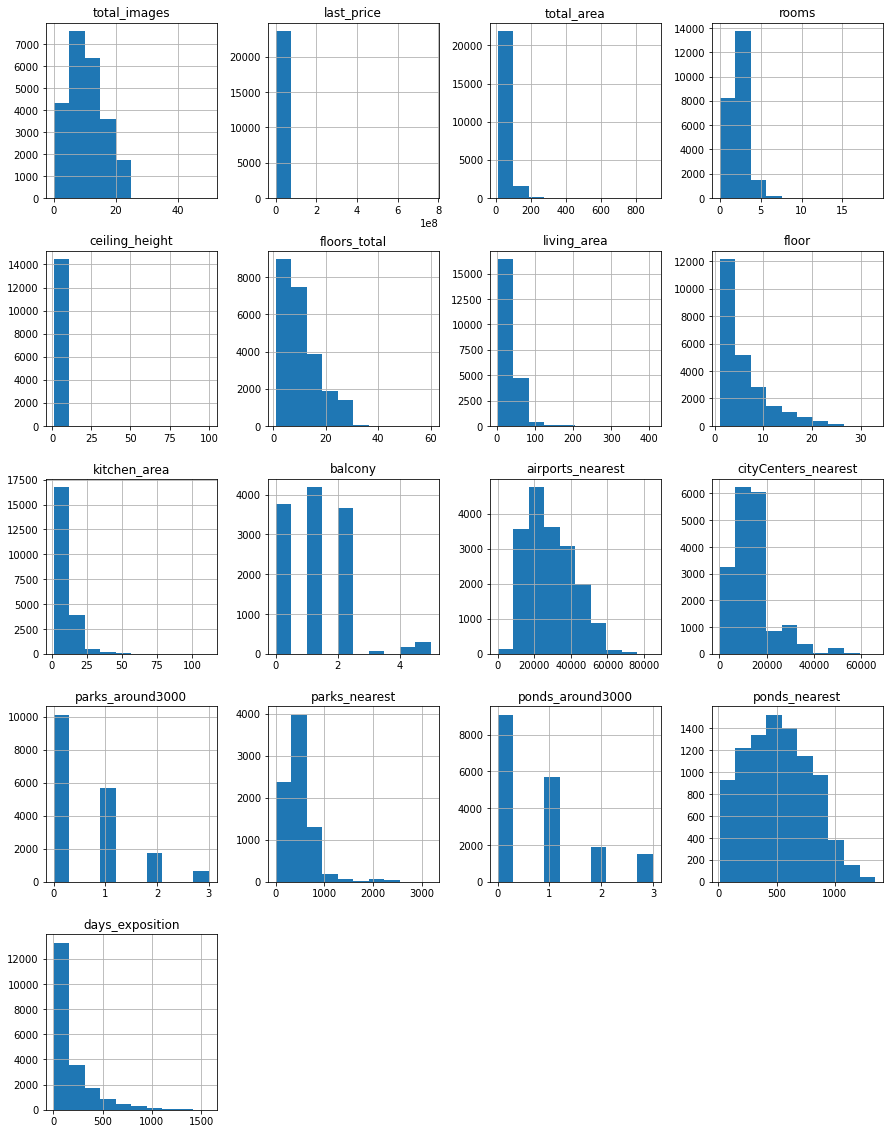

In [3]:
data.hist(figsize=(15, 20));

 - airports_nearest — расстояние до ближайшего аэропорта в метрах (м);
 - balcony — число балконов;
 - ceiling_height — высота потолков (м);
 - cityCenters_nearest — расстояние до центра города (м);
 - days_exposition — сколько дней было размещено объявление (от публикации до снятия)
 - first_day_exposition — дата публикации
 - floor — этаж
 - floors_total — всего этажей в доме
 - is_apartment — апартаменты (булев тип)
 - kitchen_area — площадь кухни в квадратных метрах (м²)
 - last_price — цена на момент снятия с публикации
 - living_area — жилая площадь в квадратных метрах (м²)
 - locality_name — название населённого пункта j
 - open_plan — свободная планировка (булев тип)
 - parks_around3000 — число парков в радиусе 3 км
 - parks_nearest — расстояние до ближайшего парка (м)
 - ponds_around3000 — число водоёмов в радиусе 3 км
 - ponds_nearest — расстояние до ближайшего водоёма (м)
 - rooms — число комнат
 - studio — квартира-студия (булев тип)
 - total_area — общая площадь квартиры в квадратных метрах (м²)
 - total_images — число фотографий квартиры в объявлении

**Вывод:** Уже на стадии ознакомления с данными видим проблемы (например: is_apartment 2775 строк, когда в других таблицах 23699 строк). Начнем немедленно выявлять проблемы с данными!

<a id="2"></a> 
### Выполните предобработку данных

Попытаемся снизить количество пропусков, где это возможно

**Количество пропусков**

In [4]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

**Количество пропусков в процентах**

In [5]:
percent = (data.isna().sum() / len(data) * 100).round(2)
percent

total_images             0.00
last_price               0.00
total_area               0.00
first_day_exposition     0.00
rooms                    0.00
ceiling_height          38.80
floors_total             0.36
living_area              8.03
floor                    0.00
is_apartment            88.29
studio                   0.00
open_plan                0.00
kitchen_area             9.61
balcony                 48.61
locality_name            0.21
airports_nearest        23.38
cityCenters_nearest     23.29
parks_around3000        23.28
parks_nearest           65.91
ponds_around3000        23.28
ponds_nearest           61.56
days_exposition         13.42
dtype: float64

- *ceiling_height* — высота потолков (м). Для замены медианными значениями сначала узнаем - сколько обьявлений с высотой потолков более 4м. Заменим медианными значениями.

In [6]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

- *floors_total* - 0.36% пропуска. Удаляем.

In [7]:
data = data.dropna(subset=['floors_total'])

- *living_area* — жилая площадь в квадратных метрах (м²). Заменим рассчитанным коэффициентом.

In [8]:
living_ratio = data['living_area'].mean() / data['total_area'].mean()
data['living_area'].fillna(living_ratio * data['total_area'], inplace=True)

- *kitchen_area* — площадь кухни в квадратных метрах (м²). Заменим рассчитанным коэффициентом.

In [9]:
kitchen_ratio = data['kitchen_area'].mean() / data['total_area'].mean()
data['kitchen_area'].fillna(kitchen_ratio * data['total_area'], inplace=True)

- *balcony* — число балконов. Заменим пропуски на 0 (нет балкона).

In [10]:
data['balcony'] = data['balcony'].fillna(0)

- *is_apartment* — апартаменты (булев тип). Нет данных 88%! Возможно это связано с тем, что пользователь не знает, является ли его недвижимость апартаментами. Стоит сообщить о проблеме разработчикам. Т.к. столбец имеет булев тип, то заменим данные на False, заодно сменив тип данных.

In [11]:
data['is_apartment'] = data['is_apartment'].fillna(False)

- *parks_around3000* — число парков в радиусе 3 км. Заменим 0 (Нет парков).

In [12]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)

- *ponds_around3000* — число водоёмов в радиусе 3 км. Заменим 0 (Нет водоемов).

In [13]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

- *locality_name* — 0.21% Пропущенных данных. Смело удаляем.

In [14]:
data = data.dropna(subset=['locality_name'])

Остальные столбцы, пропуски которых оставляем:
- *airports_nearest* — расстояние до ближайшего аэропорта в метрах (м). Наличие пропусков возможно связанно с отсутствием наличия рядом аэропорта. Замена 0 будет неккоректен из-за отдаленности населенного пункта до ближайшего аэропорта. Оставим как есть.
- *cityCenters_nearest* — расстояние до центра города (м). Возможно связанно отсутствие данных с отдаленностью объектов от центра, который высчитан до определенного радиуса. Замена 0 будет неккоректен из-за наличия других населенных пунктов, находящиеся удаленно от Санкт-Петербурга. Оставим как есть.
- *parks_nearest* — расстояние до ближайшего парка (м). Наличие пропусков связано со связью со столбцом parks_around3000. Если не имеется ближайший парк, то и данных никаких нет. Оставим значение как есть, т.к. замена на 0 исказит наши данные для анализа.
- *ponds_nearest* — расстояние до ближайшего водоёма (м). Та же ситуация, что и с parks_nearest. Оставим как есть.
- *days_exposition* — сколько дней было размещено объявление (от публикации до снятия) Так как в данных, по которым проводится исследование, много пропусков в столбце с количеством дней, сколько было размещено объявление, предположим, что эти квартиры либо очень быстро были проданы, либо не были сняты продавцом, хотя квартиру продали, либо это ошибка в данных. Замена средним или медианной не подойдет. Замена 0 также будет неккоректен. Оставим как есть.

Проверим данные на наличие явных и неявных дубликатов

**Явные дубликаты**

In [15]:
data.duplicated().sum()

0

Явных дубликатов нет

**Неявные дубликаты**

Изучим уникальные значения в столбце с названиями населенных пунктов. 

In [16]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [17]:
len(data['locality_name'].unique())

364

При проверке значений населенных пунктов наблюдаются проблемы:
- Имеется наименование "поселок" через "е" и "ё";
- Имеется разные наименования поселков ("Городской поселок", "поселок городского типа", "котеджный поселок", "поселок станции", "поселок при железнодорожной станции";
- Имеется наименования "Садовое товарищество" и "садоводческое некоммерческое товарищество";

Переименуем их

In [18]:
data['locality_name'] = (
    data['locality_name']
    .str.replace('ё', 'е')
    .replace(['садовое товарищество'], 'садоводческое некоммерческое товарищество', regex=True)
    .replace(['коттеджный поселок', 'поселок станции', 
              'поселок при железнодорожной станции', 'городской поселок', 
              'поселок городского типа'], 'поселок', regex=True) 
) 

In [19]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'поселок Шушары', 'поселок Янино-1',
       'поселок Парголово', 'поселок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок Красный Бор', 'Гатчина', 'деревня Федоровское', 'Выборг',
       'Кронштадт', 'Кировск', 'деревня Новое Девяткино',
       'поселок Металлострой', 'поселок Лебяжье', 'поселок Сиверский',
       'поселок Молодцово', 'поселок Кузьмоловский',
       'садоводческое некоммерческое товарищество Новая Ропша',
       'Павловск', 'деревня Пикколово', 'Всеволожск', 'Волхов',
       'Кингисепп', 'Приозерск', 'Сестрорецк', 'деревня Куттузи',
       'поселок Аннино', 'поселок Ефимовский', 'поселок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'поселок Новый Свет', 'Сланцы',
       'село Путилово', 'Ивангород', 'Мурино', 'Шлиссельбург',
       

In [20]:
len(data['locality_name'].unique())

318

Обработаем редкие и выбивающиеся значения (аномалии). Для этого построим для каждого численного столбца  диаграмму размаха.

In [21]:
data['last_price'].describe()

count    2.356500e+04
mean     6.540058e+06
std      1.091093e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.646000e+06
75%      6.790000e+06
max      7.630000e+08
Name: last_price, dtype: float64

Странно, у нас имеется минимальное значение квартиры 12000! Вряд ли продавец настолько щедрый, либо неправильно заполнил, забыв добавить нули. Проверим, много ли у нас таких квартир. 

In [22]:
data.query('last_price < 500000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5698,7,450000.0,42.0,2017-07-31T00:00:00,2,2.65,1.0,23.000000,1,False,...,5.800000,0.0,поселок Будогощь,NaN,NaN,0.0,NaN,0.0,NaN,233.0
6859,6,490000.0,40.0,2017-12-11T00:00:00,1,2.65,5.0,22.845471,3,False,...,7.002989,0.0,деревня Старополье,NaN,NaN,0.0,NaN,0.0,NaN,43.0
8793,7,12190.0,109.0,2019-03-20T00:00:00,2,2.75,25.0,32.000000,25,False,...,40.500000,0.0,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0
9581,7,450000.0,43.4,2018-08-31T00:00:00,2,2.65,5.0,30.300000,3,False,...,5.500000,0.0,деревня Старополье,NaN,NaN,0.0,NaN,0.0,NaN,96.0
10782,3,490000.0,29.1,2016-05-05T00:00:00,1,2.50,5.0,17.000000,5,False,...,5.500000,0.0,Сланцы,NaN,NaN,0.0,NaN,0.0,NaN,719.0
14911,5,430000.0,54.0,2018-06-26T00:00:00,2,2.65,3.0,30.841386,3,False,...,9.454035,0.0,поселок Свирь,NaN,NaN,0.0,NaN,0.0,NaN,44.0
16032,8,480000.0,32.0,2019-01-06T00:00:00,1,2.65,2.0,16.000000,1,False,...,5.602391,0.0,Сланцы,NaN,NaN,0.0,NaN,0.0,NaN,83.0
16219,14,450000.0,38.5,2018-07-11T00:00:00,2,2.65,2.0,21.988766,1,False,...,6.740377,0.0,деревня Вахнова Кара,NaN,NaN,0.0,NaN,0.0,NaN,45.0
16274,18,440000.0,40.0,2018-07-10T00:00:00,1,2.65,5.0,22.845471,1,False,...,7.002989,0.0,деревня Старополье,NaN,NaN,0.0,NaN,0.0,NaN,45.0
17456,7,430000.0,30.4,2019-04-22T00:00:00,1,2.65,2.0,16.000000,1,False,...,6.000000,0.0,Сланцы,NaN,NaN,0.0,NaN,0.0,NaN,NaN


Имеется только одно обьявление меньше 100000. Смело удаляем!

In [23]:
data = data.query('last_price > 100000')

In [24]:
data['ceiling_height'].describe()

count    23564.000000
mean         2.724529
std          0.991047
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

Странная высота потолков. Самая низкая 1 м и самая высокая 100. Возможно связанно, что . Узнаем, сколько таких потолков вы больше 5м

In [25]:
len(data.query('ceiling_height > 5 or ceiling_height < 2.5 '))

109

109 значений высота потолков. Удалим эти значения.

In [26]:
data = data.query('2.5 < ceiling_height < 5')

Заменим тип данных:

- last_price - Уберем лишние копейки. Меняем на int и округляем до тысяч. для удобства посторения гистограммы.
- floors_total - Число этажей может быть только целым. Меняем на int
- is_apartment - Булевое значение. Меняем на bool
- balcon - Количество балконов также может быть только целым. Меняем на int.
- parks_around3000 - Число парков. Меняем на int
- ponds_around3000 - Число водоемов. Меняем на int
- first_day_exposition - Дата публиуования объявления. Меняем на datetime, заодно переведется в удобный для работы формат.
- days_exposition - Стоит заменить на int, но в связи с наличием пропусков в столбце оставим как есть.

In [27]:
data['last_price'] = (data['last_price']/1000).astype(int)
data['floors_total'] = data['floors_total'].astype(int)
data['is_apartment'] = data['is_apartment'].astype(bool)
data['balcony'] = data['balcony'].astype(int)
data['parks_around3000'] = data['parks_around3000'].astype(int)
data['ponds_around3000'] = data['ponds_around3000'].astype(int)
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [28]:
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000,108.00,2019-03-07,3,2.70,16,51.000000,8,False,...,25.000000,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN
1,7,3350,40.40,2018-12-04,1,2.65,11,18.600000,1,False,...,11.000000,2,поселок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0
2,10,5196,56.00,2015-08-20,2,2.65,5,34.300000,4,False,...,8.300000,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0
3,0,64900,159.00,2015-07-24,3,2.65,14,90.810749,9,False,...,27.836882,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0
4,2,10000,100.00,2018-06-19,2,3.03,14,32.000000,13,False,...,41.000000,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23693,9,4600,62.40,2016-08-05,3,2.60,9,40.000000,8,False,...,8.000000,0,Петергоф,45602.0,34104.0,1,352.0,1,675.0,239.0
23694,9,9700,133.81,2017-03-21,3,3.70,5,73.300000,3,False,...,13.830000,0,Санкт-Петербург,24665.0,4232.0,1,796.0,3,381.0,NaN
23695,14,3100,59.00,2018-01-15,3,2.65,5,38.000000,4,False,...,8.500000,0,Тосно,NaN,NaN,0,NaN,0,NaN,45.0
23696,18,2500,56.70,2018-02-11,2,2.65,3,29.700000,1,False,...,9.926737,0,село Рождествено,NaN,NaN,0,NaN,0,NaN,NaN


**Вывод:**
Мы преобработали данные, удалив аномальные значения, убрав пропуски там, где это логически возможно, не влияя в дальнейшем на расчеты. Заменили тип данных везде, где необходимо, а также избавились от неявных дубликатов.

<a id="3"></a> 
### Добавьте в таблицу новые столбцы

Посчитаем цену квадратного метра

In [29]:
data['price_per_square_meter'] = (data['last_price'] / data['total_area']).round(2)

Создадим столбец дня недели

In [30]:
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday

Создадим столбец месяца

In [31]:
data['month_exposition'] = data['first_day_exposition'].dt.month

Создадим столбец года

In [32]:
data['year_exposition'] = data['first_day_exposition'].dt.year

Добавим категоризацию по этажам, написав простую функцию

In [33]:
def floor_category(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    elif 1 < floor < floors_total:
        return 'другой'
    
data['floor_category'] = data.apply(floor_category, axis = 1)

Добавим столбец расстояния до центра города в километрах

In [1]:
data['cityCenters_nearest_km'] = (data['cityCenters_nearest']/1000).round(0)
data

NameError: name 'data' is not defined

**Вывод:** Мы добавили 6 новых столбцов для дальнейших расчетов, а именно:
 -  цена одного квадратного метра (нужно поделить стоимость объекта на его общую площадь, а затем округлить до двух знаков после запятой);
 - день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
 - месяц публикации объявления;
 - год публикации объявления;
 - тип этажа квартиры (значения — «‎первый», «последний», «другой»);
 - расстояние до центра города в километрах (переведите из м в км и округлите до ближайших целых значений).

<a id="4"></a> 
### Проведите исследовательский анализ данных

 Построим гистограммы следующих столбцов:
 - общая площадь;
 - жилая площадь;
 - площадь кухни;
 - цена объекта;
 - количество комнат;
 - высота потолков;
 - тип этажа квартиры («первый», «последний», «другой»);
 - общее количество этажей в доме;
 - расстояние до центра города в метрах;
 - расстояние до ближайшего парка.

**Общая площадь**

<AxesSubplot:>

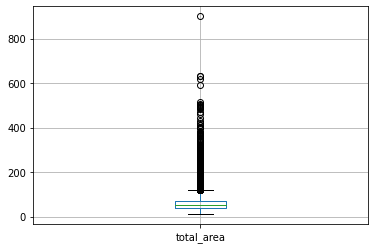

In [35]:
data.boxplot(column=['total_area'])

<AxesSubplot:>

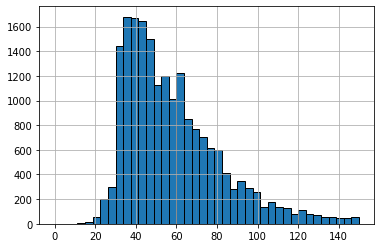

In [86]:
data['total_area'].hist(bins = 40, range = (0,150),ec='black')

**Вывод:** Чаще всего продают квартиры, общая площадь которая от 25 до 80 кв.м. Все, что выше - элитное жилье, ниже - квартиры-студии.

**Жилая площадь**

<AxesSubplot:>

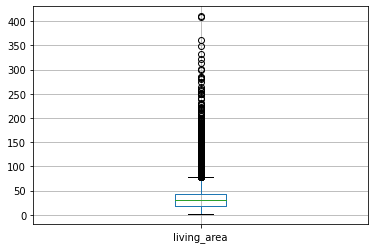

In [37]:
data.boxplot(column=['living_area'])

<AxesSubplot:>

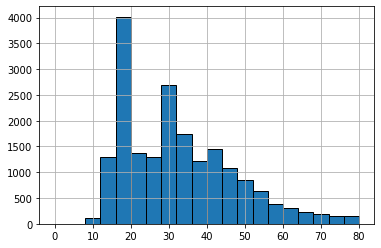

In [38]:
data['living_area'].hist(bins = 20, range = (0,80),ec='black')

**Вывод:** Чаще всего продают квартиры, жилая площадь которая от 15 до 45 кв.м. Все, что выше - либо многоквартирные объекты, либо коттеджи, либо элитное жилье.

**Площадь кухни**

<AxesSubplot:>

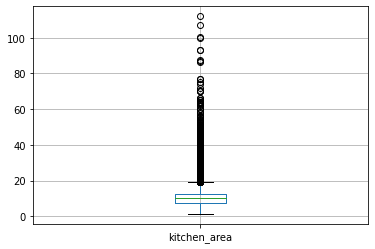

In [39]:
data.boxplot(column=['kitchen_area'])

<AxesSubplot:>

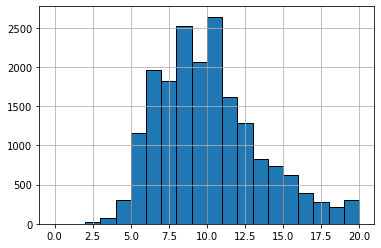

In [40]:
data['kitchen_area'].hist(bins = 20, range = (0,20),ec='black')

**Вывод:** Чаще всего продают квартиры, дилая площадь которая от 6 до 12 кв.м. 6 кв.м. кухня и меньше могут быть квартирами-студиями, которые кухни как таковой не предусматривает, и берется любая свободная под кухню площадь.

**Цена объекта**

<AxesSubplot:>

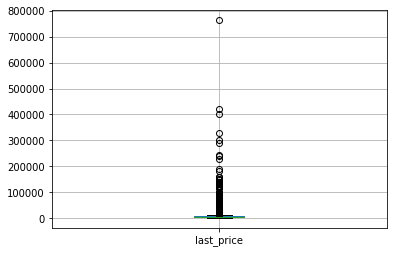

In [41]:
data.boxplot(column=['last_price'])

<AxesSubplot:>

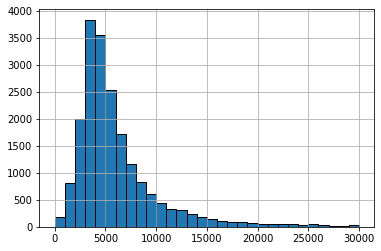

In [42]:
data['last_price'].hist(bins=30, range=(0,30000), ec='black')

**Вывод:** Больше всего квартир продается в цене от 3 млн до 8 млн. Все, что выше - элитное жилье или сильно завышенная стоимость по рынку.

**Количество комнат**

<AxesSubplot:>

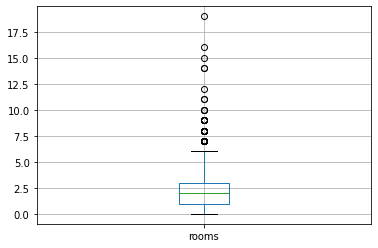

In [43]:
data.boxplot(column=['rooms'])

<AxesSubplot:>

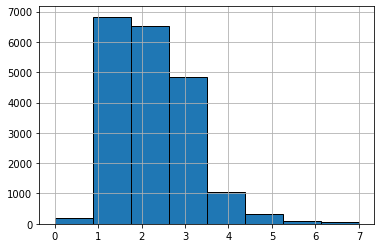

In [44]:
data['rooms'].hist(bins = 8, range = (0, 7) ,ec='black')

**Вывод:** 1,2,3 комнатные квартиры. Значения, которые равны 0 связаны с тем, что это квартира-студия. Большое кол-во комнат (от 4 и выше) скорее всего у объектов, которые относятся к элитным.

**Высота потолков**

<AxesSubplot:>

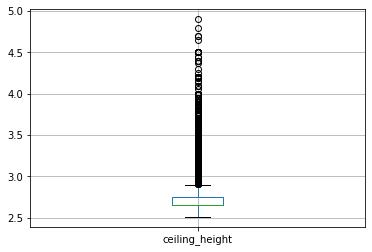

In [45]:
data.boxplot(column=['ceiling_height'])

<AxesSubplot:>

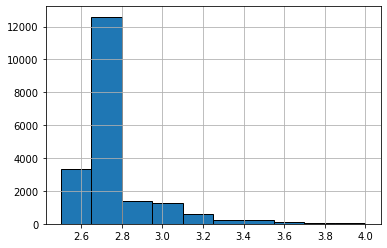

In [46]:
data['ceiling_height'].hist(bins = 10, range=(2.5,4), ec='black')

**Вывод**: Больше всего объявлений по продаже квартир от 2.5 до 2.8м. Это может быть связано с типажом домов. у "Хрущевок" высота потолков в среднем от 2,48 до 2,7 (Уточнение: для подтверждения данной гипотезы нужны дополнительные данные, но в данном проекте не будем ее рассматривать). 

**Тип этажей**

<AxesSubplot:>

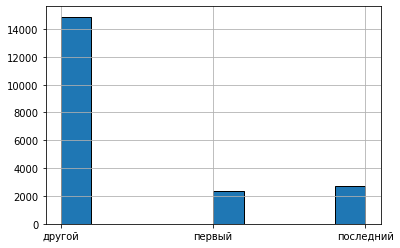

In [47]:
data['floor_category'].hist(ec='black')

**Вывод:** Больше всего квартир на 2 и выше  (кроме последних) этажах. И это очевидно, с учетом, что в большинстве у нас в стране многоэтажные дома, а также 2 этажные коттежди и частные дома.

**Общее количество этажей**

<AxesSubplot:>

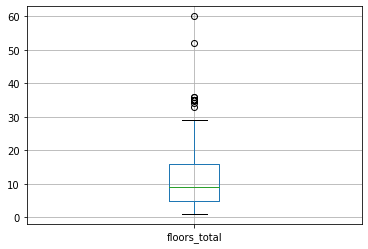

In [48]:
data.boxplot(column=['floors_total'])

<AxesSubplot:>

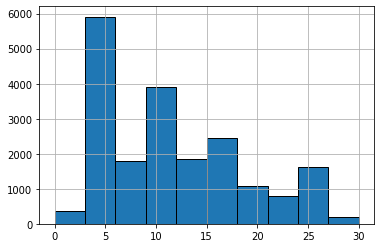

In [49]:
data['floors_total'].hist(bins = 10,range=(0,30), ec='black')

**Вывод:** Больше всего квартир продается в зданиях где 5 - 10 этажей. Это связано с большим наличием в населенных пунктах Хрущевок (5-этажные дома) и "Брежневок" (9-этажные дома).

**Расстояние до центра города (м)**

<AxesSubplot:>

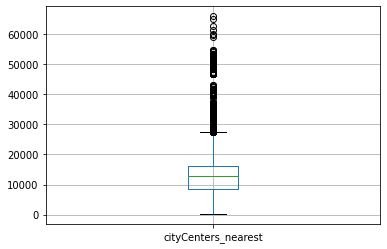

In [50]:
data.boxplot(column=['cityCenters_nearest'])

<AxesSubplot:>

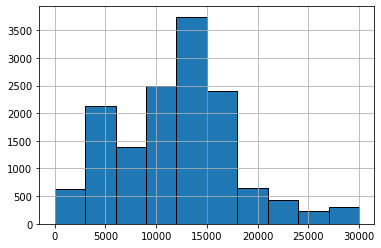

In [51]:
data['cityCenters_nearest'].hist(range=(0,30000), ec='black')

**Вывод:** Больше всего объектов продается в отдаленности от центра (В поселках, деревнях, селах). Больше всего объявлений в отдаленности от 10000 м до 18000 м.

**Расстояние до ближайшего парка**

<AxesSubplot:>

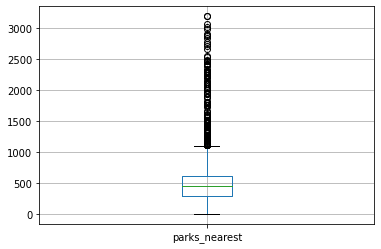

In [52]:
data.boxplot(column=['parks_nearest'])

<AxesSubplot:>

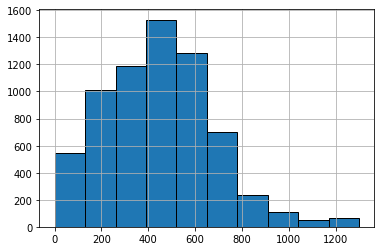

In [53]:
data['parks_nearest'].hist(range=(0,1300), ec='black')

**Вывод:** Больше всего объявлений, где парк располагается от 200 м до 800 м. 

**Исследование времени продажи объекта**

Построим гистограмму по столбцу days_exposition - сколько дней было размещено объявление (от публикации до снятия)

<AxesSubplot:>

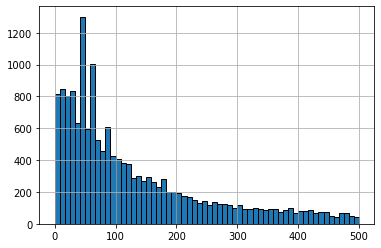

In [54]:
data['days_exposition'].hist(bins = 60, range=(0,500), ec='black')

Имеются 2 странных пика от 40 до 60 дней, отличающихся от среднего. Рассмотрим поближе.

<AxesSubplot:>

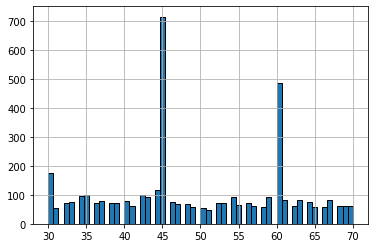

In [55]:
data['days_exposition'].hist(bins = 60, range=(30,70), ec='black')

Больше всего закрытий объявлений на 45 дне и 60 дне. Возможно, это связано, что сервис предлагает закрыть объявление раньше. Лучше уточнить эту информацию у разработчиков.

Найдем среднее количество дней продажи объекта

In [56]:
data['days_exposition'].mean()

183.46114971572962

Найдем медиану количества дней продажи объекта

In [57]:
data['days_exposition'].median()

97.0

**Вывод:** В среднем продажа квартиры занимает 3 месяца. Очень редко продаются квартиры больше 2 лет. Больше всего закрытий объявлений на 45 дне и 60 дне. Также вероятно объявления, которые висят больше 2 лет просто вовремя не закрывали

**Определим факторы, которые больше всего влияют на общую (полную) стоимость объекта.**

Нас конкретно интересует зависимость цены от:

    общей площади;
    жилой площади;
    площади кухни;
    количества комнат;
    этажа, на котором расположена квартира (первый, последний, другой);
    даты размещения (день недели, месяц, год).

Для этажа, на котором расположена квартира (первый, последний, другой) сменим обозначение столбца:
- первый - 1
- другой - 2
- последний - 3

In [58]:
data['floor_category'] = (
    data['floor_category']
    .replace('первый', 1)
    .replace('другой', 2)
    .replace('последний', 3)
) 

In [59]:
price_table = data.loc[:,['last_price','total_area', 'living_area','kitchen_area',
 'rooms','floor_category','weekday_exposition', 'month_exposition','year_exposition']] 
price_table.corr()

,last_price,total_area,living_area,kitchen_area,rooms,floor_category,weekday_exposition,month_exposition,year_exposition
last_price,1.000000,0.650582,0.583261,0.507832,0.371852,0.063490,-0.000145,0.001186,-0.035636
total_area,0.650582,1.000000,0.947158,0.654058,0.770299,0.072158,-0.009014,0.004059,-0.066474
living_area,0.583261,0.947158,1.000000,0.500734,0.833005,0.066350,-0.007852,-0.000532,-0.063529
kitchen_area,0.507832,0.654058,0.500734,1.000000,0.344190,0.056236,-0.008789,0.001371,-0.040017
rooms,0.371852,0.770299,0.833005,0.344190,1.000000,0.033826,-0.008436,-0.003638,-0.055538
floor_category,0.063490,0.072158,0.066350,0.056236,0.033826,1.000000,0.008270,0.008484,0.001288
weekday_exposition,-0.000145,-0.009014,-0.007852,-0.008789,-0.008436,0.008270,1.000000,0.022151,-0.000290
month_exposition,0.001186,0.004059,-0.000532,0.001371,-0.003638,0.008484,0.022151,1.000000,-0.260240
year_exposition,-0.035636,-0.066474,-0.063529,-0.040017,-0.055538,0.001288,-0.000290,-0.260240,1.000000


Построим диаграмму распределения

array([[<AxesSubplot:xlabel='last_price', ylabel='last_price'>,
        <AxesSubplot:xlabel='total_area', ylabel='last_price'>,
        <AxesSubplot:xlabel='living_area', ylabel='last_price'>,
        <AxesSubplot:xlabel='kitchen_area', ylabel='last_price'>,
        <AxesSubplot:xlabel='rooms', ylabel='last_price'>,
        <AxesSubplot:xlabel='floor_category', ylabel='last_price'>,
        <AxesSubplot:xlabel='weekday_exposition', ylabel='last_price'>,
        <AxesSubplot:xlabel='month_exposition', ylabel='last_price'>,
        <AxesSubplot:xlabel='year_exposition', ylabel='last_price'>],
       [<AxesSubplot:xlabel='last_price', ylabel='total_area'>,
        <AxesSubplot:xlabel='total_area', ylabel='total_area'>,
        <AxesSubplot:xlabel='living_area', ylabel='total_area'>,
        <AxesSubplot:xlabel='kitchen_area', ylabel='total_area'>,
        <AxesSubplot:xlabel='rooms', ylabel='total_area'>,
        <AxesSubplot:xlabel='floor_category', ylabel='total_area'>,
        <AxesSub

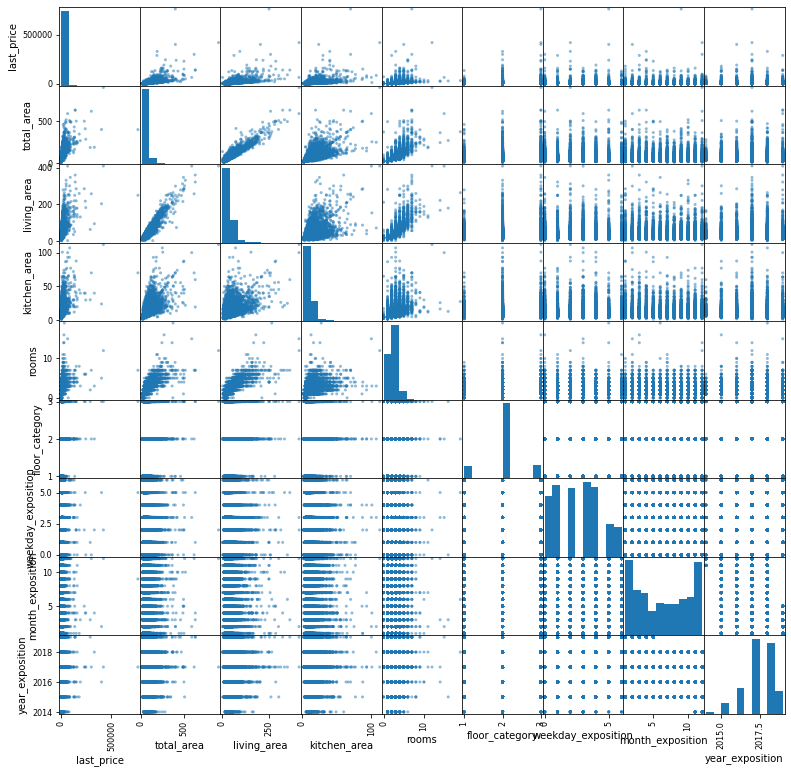

In [60]:
pd.plotting.scatter_matrix(price_table, figsize=(13,13))

**Вывод:** Цена имеет зависимость в особенности от общей площади, а конкретно от жилой площади. Меньше от площади кухни и количества комнат и полностью отсутствует связь от даты размещения объявления. Квартиры остаются актуальной покупкой в любое время года.

**Населённые пункты с самой высокой и низкой стоимостью квадратного метра**

Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра. Но для этого будем искать не по среднему, а по медиане, т.к. имеются объекты стоимостью более 50 млн, что влияет на общий вывод.

In [61]:
(
    data.pivot_table(index='locality_name', 
                 values=['price_per_square_meter'],
                 aggfunc={'locality_name':'count','price_per_square_meter':'median'})
        .rename(columns={'locality_name': 'counts'})
        .sort_values(by=['counts','price_per_square_meter'], ascending=False)
        .head(10)
)

,counts,price_per_square_meter
locality_name,,
Санкт-Петербург,13492,106.240
поселок Мурино,542,86.060
поселок Шушары,410,76.750
Всеволожск,366,65.880
поселок Парголово,312,91.985
деревня Кудрово,298,91.830
Пушкин,290,100.200
Гатчина,235,68.140
Колпино,234,74.865


**Вывод:** Больше всего стоимость соответсвенно в Санкт-Петербурге - 106 тыс за кв.м. что выглядит как правда - стоимость в столице всегда выше, чем на окрайне. Меньше всего стоимость в Выборге - 58 тыс за кв.м. 

**Средняя стоимость квартир в Санкт-Петербурге на разном удалении от центра**

Исследуем стоимость квартир в Санкт-Петербурге на расстоянии от центра.

In [62]:
cityCenters_price_km = data.query('locality_name == "Санкт-Петербург"').pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc={'cityCenters_nearest_km':'count','last_price':'mean'}).rename(columns={'cityCenters_nearest_km': 'counts'})
cityCenters_price_km

,counts,last_price
cityCenters_nearest_km,,
0.0,27,31449.074074
1.0,185,21569.670270
2.0,308,17824.607143
3.0,339,11003.861357
4.0,675,13383.952593
5.0,899,14391.731924
6.0,580,15698.706897
7.0,389,15234.706941
8.0,523,10452.156788


Построим гистограмму.

<AxesSubplot:xlabel='cityCenters_nearest_km'>

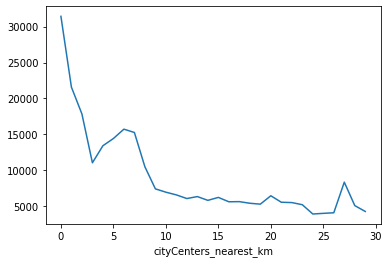

In [63]:
cityCenters_price_km['last_price'].plot()

**Вывод:** Как и ожидалось, с самом центре стоимость квартиры начинается от 30 млн и постепенно снижается в зависимости от удаленности от центра. Можем также наблюдать, начинающийся с 3 км до 7 км от центра. это может быть связано, что в Санкт-Петербурге примерно на этом расстоянии находятся Василеостровсий и Петроградский район, объекты которые считаются элитными и соответственно стоимость их превышает 10 млн. Также наблюдается аномальный пик с 26 до 28 км. Возможно это связано с расположением в этом радиусе крупных поселков (Красное село, Пушкино, Колпино и пр.)

<a id="5"></a> 
### Напишите общий вывод

В ходе первой части проекта была проведена важная работа по предварительной обработке данных. Очистка данных является ключевым в анализе данных, поскольку она позволяет удалить ошибки, выбросы и пропуски, обеспечивая более точные результаты. Разнообразие форматов записей данных может затруднять их анализ и сопоставление. Поэтому необходимо изменить тип данных, что уменьшит вероятность ошибок в будущем. Также важным шагом является определение ключевых параметров для анализа данных.

По результатам исследования данных о недвижимости были сделаны следующие выводы:
   - Общая площадь квартир варьируется от 25 до 80 квадратных метров.
   - Жилая площадь варьируется от 15 до 45 квадратных метров.
   - Площадь кухни варьируется от 6 до 12 квадратных метров.
   - Цена объекта колеблется от 3 до 8 миллионов рублей.
   - Большинство квартир имеют 1, 2 или 3 комнаты.
   - Высота потолков варьируется от 2.5 до 2.8 метров.
   - Общее количество этажей варьируется в среднем от 5 до 10 этажей.
   - Расстояние до центра города составляет от 10 000 до 18 000 метров.
   - Большинство объявлений относится к квартирам, где парк находится в пределах от 200 до 800 метров.
   
Эти данные позволяют провести детальный анализ рынка недвижимости в Санкт-Петербурге и определить основные факторы, влияющие на цену квартир.

Добавление новых столбцов в данные, таких как цена за квадратный метр, день, месяц и год публикации объявления, тип этажа квартиры, расстояние до центра города в километрах, а также цена за квартиру в миллионах, является важным этапом в подготовке данных для дальнейшего анализа. Эти столбцы уточняют характеристики квартир и их окружения, что может быть полезно для понимания тенденций на рынке недвижимости.

В целом, результаты исследования позволяют сделать вывод, что качественные характеристики, такие как общая площадь, жилая площадь, площадь кухни и количество комнат, существенно влияют на формирование цены квартиры. В то же время параметры, связанные с датой и временем публикации объявления, оказывают незначительное влияние на цену.

Цена недвижимости зависит от расстояния до центра города: чем ближе к центру, тем выше цена за квадратный метр. Это объясняется наличием в центре всех удобств, культурных центров и других объектов инфраструктуры, делающих район более привлекательным для проживания и инвестирования. Далее от центра обычно находятся спальные районы, что также влияет на цену недвижимости, так как они менее привлекательны для проживания и имеют меньшее количество развлекательных и инфраструктурных объектов.